<a href="https://colab.research.google.com/github/FabianC22/Dimplomado_Ciencia_Datos/blob/main/Tareas/Taller_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

print('version de tf: ', tf.__version__)

from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 

version de tf:  2.12.0


Se carga la base de datos de las acciones de Ecopetrol

In [ ]:
name_excel='Eco.xlsx'
sheet='Hoja1'
df=pd.read_excel(name_excel, sheet)

In [ ]:
df.head()



,Date,Open,High,Low,Close,AdjClose,Volume
0,2009-01-02,18.490000,18.49,18.290001,18.400000,7.724421,7600
1,2009-01-05,18.490000,19.00,18.309999,19.000000,7.976305,15700
2,2009-01-06,18.870001,19.50,18.500000,19.299999,8.102245,28200
3,2009-01-07,20.000000,20.00,18.570000,18.600000,7.808383,33400
4,2009-01-08,18.500000,19.00,18.350000,18.700001,7.850362,17700


In [ ]:
Estadisticas=df.describe().T
Estadisticas

,count,mean,std,min,25%,50%,75%,max
Open,2767.0,28.051691,16.250286,5.360000,15.490000,24.340000,41.885000,6.711000e+01
High,2767.0,28.382201,16.373014,5.500000,15.810000,24.709999,42.269998,6.792000e+01
Low,2767.0,27.676093,16.087354,5.160000,15.245000,23.799999,41.349998,6.605000e+01
Close,2767.0,28.040726,16.241125,5.400000,15.510000,24.240000,41.844999,6.748000e+01
AdjClose,2767.0,14.861573,7.726540,3.367232,7.850362,12.941478,20.236080,3.423208e+01
Volume,2767.0,672067.148536,560556.507706,5100.000000,284700.000000,549000.000000,920950.000000,5.466800e+06


In [ ]:
TRAIN_SPLIT=1937 ### 70% de los datos, las primeras filas de 2767
tf.random.set_seed(15464) ### semilla
##Pronóstico de una serie de tiempo multivariada
## variables a utilizar 
features_considered = ['Open', 'High', 'Low',"Close","AdjClose"]
features = df[features_considered]
features.index = df['Date']
features.head()


,Open,High,Low,Close,AdjClose
Date,,,,,
2009-01-02,18.490000,18.49,18.290001,18.400000,7.724421
2009-01-05,18.490000,19.00,18.309999,19.000000,7.976305
2009-01-06,18.870001,19.50,18.500000,19.299999,8.102245
2009-01-07,20.000000,20.00,18.570000,18.600000,7.808383
2009-01-08,18.500000,19.00,18.350000,18.700001,7.850362


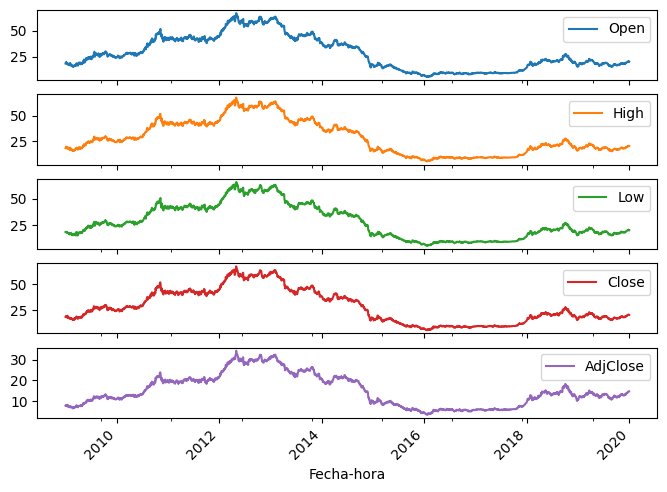

In [ ]:
features.plot(subplots=True, rot=45, xlabel='Fecha-hora')
plt.show()

In [ ]:
### Estandarizar 

dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)


dataset = (dataset-data_mean)/data_std

In [ ]:
### Modelo de un Paso 

past_history = 365  ## dos años atras 
future_target = 1 ##  Una día adelante 
STEP = 1  


In [ ]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    ''' dataset: conjunto de datos para las secuencias de entrada
        target:  conjunto de datos para las secuencias de salida
        start_index: índice inicial de donde empezar a tomar los datos
        end_index: índice final para tomar los datos. None para tomarlos todos
        history_size: tamaño de la venytana para crear las secuencias
        target_size: dentro de cuántas observaciones futuras desea pronosticar
        step: Cada cuántas observaciones deben tomarse. Para secuencias muy largas
              que no cambia mucho localmente
        single_step: Predecir solamente un valor futuro (=True),
                     o predecir todos los valores hasta target_size(=False)
    '''  
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)


In [ ]:
x_train_single, y_train_single = multivariate_data(dataset[:, :4], dataset[:, 4], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset[:, :4], dataset[:, 4],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)




print(dataset.shape)
print(x_train_single.shape) 
print(y_train_single.shape)
print(x_val_single.shape)
print(y_val_single.shape)

print ('Ventana ejemplo de la historia pasada : {}'.format(x_train_single[0].shape))



(2767, 5)
(1572, 365, 4)
(1572,)
(464, 365, 4)
(464,)
Ventana ejemplo de la historia pasada : (365, 4)


In [ ]:
#Crea objetos tf.data.Dataset para entreno y validación
#Para manejo más eficiente de memoria

BATCH_SIZE = 5
BUFFER_SIZE = 25 ### 10 % de los datos garantiza la aleatoriedad

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()



In [ ]:
# Modelo LSTM

input_shape = (x_train_single.shape[1], x_train_single.shape[2])
units = 100
drop_out_rate = 0.0

In [ ]:
# layers
inputs = Input(input_shape)
x = Dropout(drop_out_rate, name= 'Dropout_01')(inputs)
x = LSTM(units=units, name='LSTM_layer',
         dropout=drop_out_rate, recurrent_dropout=drop_out_rate)(x)
x = Dropout(drop_out_rate, name= 'Dropout_02')(x)
outputs = Dense(1)(x)


In [ ]:
# model
single_step_model = Model(inputs=inputs, outputs=outputs, name='series_LSTM_model')
single_step_model.summary()

#Compila
#Usamos la función de costo mean absolute error definida po

single_step_model.compile(optimizer=Adam(), loss='mae')

#Revisemos una predicción simple

Model: "series_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 365, 4)]          0         
                                                                 
 Dropout_01 (Dropout)        (None, 365, 4)            0         
                                                                 
 LSTM_layer (LSTM)           (None, 100)               42000     
                                                                 
 Dropout_02 (Dropout)        (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 42,101
Trainable params: 42,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Revisemos una predicción simple

for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

1/1 [==============================] - 1s 674ms/step
(5, 1)


In [ ]:
#Entrena

EVALUATION_INTERVAL = 100
EPOCHS = 20
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


Epoch 1/20
100/100 [==============================] - 18s 160ms/step - loss: 0.0928 - val_loss: 0.4071
Epoch 2/20
100/100 [==============================] - 15s 150ms/step - loss: 0.0830 - val_loss: 0.7861
Epoch 3/20
100/100 [==============================] - 15s 154ms/step - loss: 0.0622 - val_loss: 0.3287
Epoch 4/20
100/100 [==============================] - 16s 159ms/step - loss: 0.0973 - val_loss: 0.4027
Epoch 5/20
100/100 [==============================] - 15s 148ms/step - loss: 0.0796 - val_loss: 0.4354
Epoch 6/20
100/100 [==============================] - 16s 164ms/step - loss: 0.0601 - val_loss: 0.2905
Epoch 7/20
100/100 [==============================] - 26s 257ms/step - loss: 0.1127 - val_loss: 0.3167
Epoch 8/20
100/100 [==============================] - 16s 156ms/step - loss: 0.0783 - val_loss: 0.5686
Epoch 9/20
100/100 [==============================] - 16s 160ms/step - loss: 0.0761 - val_loss: 0.2749
Epoch 10/20
100/100 [==============================] - 16s 159ms/step - l

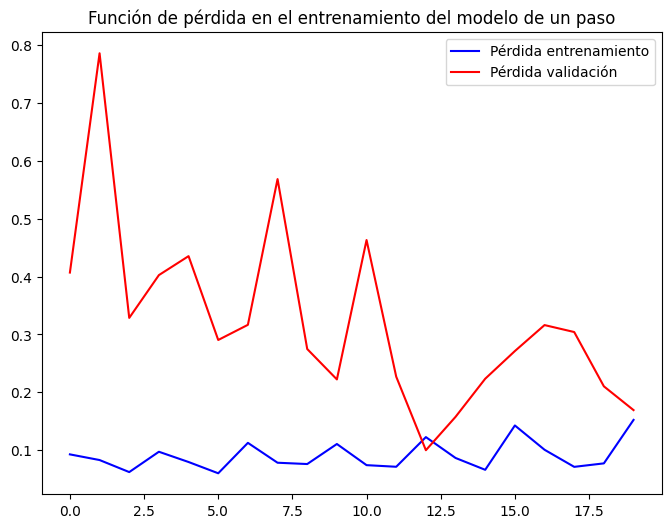

In [ ]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Pérdida entrenamiento')
    plt.plot(epochs, val_loss, 'r', label='Pérdida validación')
    plt.title(title)
    plt.legend()

    plt.show()

plot_train_history(single_step_history,
                   'Función de pérdida en el entrenamiento del modelo de un paso')


1/1 [==============================] - 0s 42ms/step


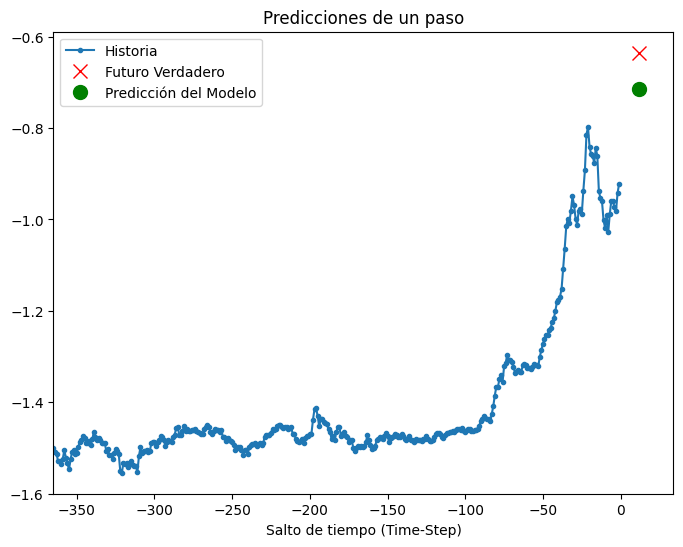

1/1 [==============================] - 0s 39ms/step


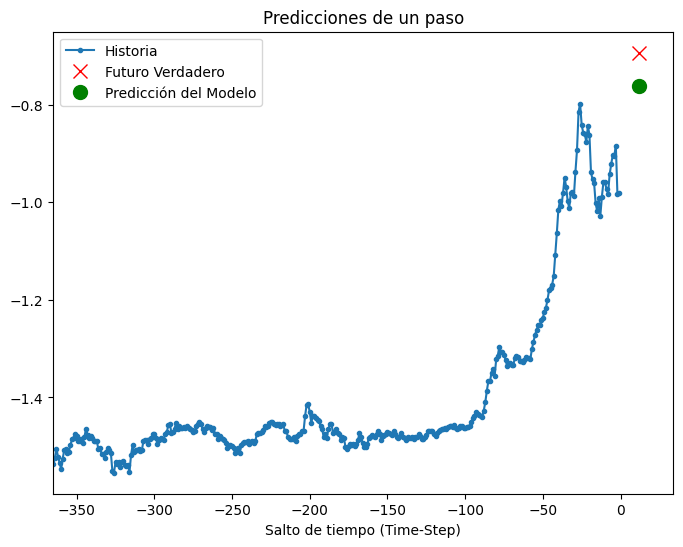

1/1 [==============================] - 0s 40ms/step


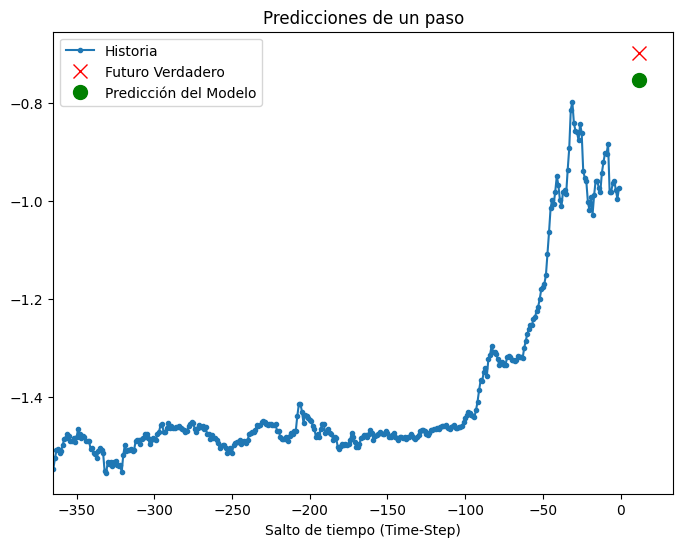

In [ ]:
# Predicciones

def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['Historia', 'Futuro Verdadero' , 'Predicción del Modelo']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Salto de tiempo (Time-Step)')
  return plt

for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Predicciones de un paso')
    plot.show()


In [ ]:
y_pred =[]


y_pred = single_step_model.predict(x_val_single)
y_pred = np.squeeze(y_pred,axis=1)
y_test = y_val_single

print(y_pred.shape)
print(y_test.shape)


15/15 [==============================] - 1s 58ms/step
(464,)
(464,)


0.1978010019043543


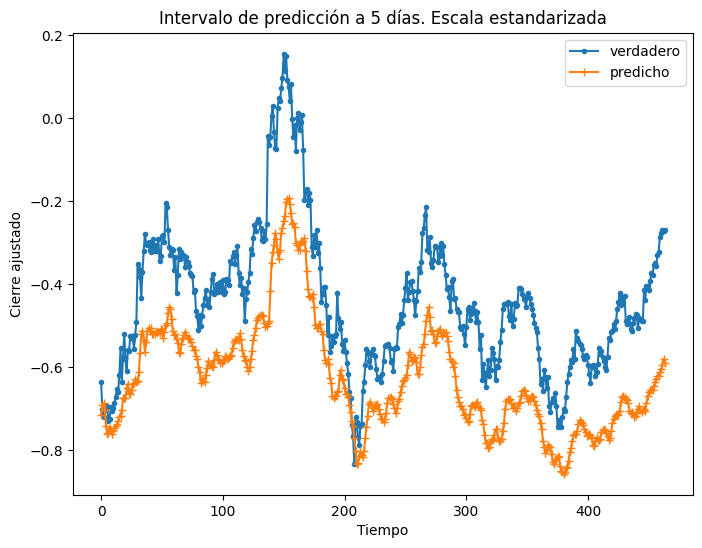

In [ ]:
##rms

rmsLSTM = np.sqrt(np.mean(np.power(y_pred-y_test,2)))
print(rmsLSTM )

def plot_series(y_test,y_pred, title, x_label, y_label,rms,epochs):
    plt.plot(np.arange(0, len(y_test)), y_test, marker='.', label="verdadero")
    plt.plot(np.arange(0, len(y_test)), y_pred, marker='+', label="predicho")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.annotate("rms="+str(round(rms,2)) , xy=(500, 1.3), size = 10)
    #plt.annotate("modelo = LSTM(50), timestep=60" , xy=(100, 146), size = 15)
    #
    plt.annotate("epochs="+str(epochs) , xy=(500, 1.5), size = 10)
    plt.title(title)
    plt.legend()
    plt.show()
    

title = "Intervalo de predicción a 5 días. Escala estandarizada"
x_label = 'Tiempo'
y_label = 'Cierre ajustado'
rms = rmsLSTM
plot_series(y_test[:2000], y_pred[:2000],title,x_label, y_label, rms,epochs=10 )


